## Table of contents

* [1. Background](#Background)
* [2. Imports](#import)
* [3. Load the data](#Load_Data)
* [4. Is the data imbalanced?](#imblnc)
* [5. Definie predictive features and target feature](#define)
* [6. Appply One Hot Encoder to change the categorical columns](#OneHot)
* [7. Use RandomUnderSampler to balance the data](#rus)
* [8. Split the data to train and test sets](#split)
* [9. Choose the right metrics for model evaluation](#metrics)
* [10. Train models](#model)
    * [9.1. Logistic regression](#lr)
        * [9.1.1.  Make a pipeline for logistic regression model training](#pllr)
        * [9.1.2. Hyperparameter search using GridSearchCV for logistic regression](#gdlr)
        * [9.1.3. Best Logistic Regression model](#bestlr)
    * [9.2. Decision tree classifier](#dt)
        * [9.2.1. Make a pipeline for decision tree](#pldt)
        * [9.2.2. Hyperparameter search for decision tree classifier](#gddt)
        * [9.2.3. Decision tree classifier with best parameters](#bestdt)
        * [9.2.4. Feature importance assessment in the decision tree classifier](#fidt)
    * [9.3. Random forest classifier](#rf)
        * [9.3.1. Make a pipeline for random forest classifier](#plrf)
        * [9.3.2. Hyperparameter search for random forest classifier](#gdrf)
        * [9.3.3. Rondom forest classifier feature importance assessment](#firf)
    * [9.4. Gradient boosting classifier](#GB)
        * [9.4.1. Make a pipeline for gradient boosting classifier](#plgb)
        * [9.4.2. Hyperparameter tuning for gradient boosting classifier](#gdgb)
        * [9.4.3. Gradient boosting feature importance assessment](#figb)
* [10. Summary](#discussion)    

# 1. Background  <a class='anchor' id='Background'></a>

In this notebook we will apply several calssification models to our cleaned data frame of accepted loans from Lending Club. Briefly, Lending Club used to be the biggest peer to peer lending platform. To decide about a loan application, Lending Club relies on applicants' information provided during application. Such information includes income, length employment and credit history. In previous notebooks, we addressed missing data and explore the data to get a better understanding of the data 

In this notebook we will apply several classification models to predict if a loan will default. The models are:

1. Logistic regression

2. Decision tree

3. Random Forest



# 2. Imports <a class='anchor' id='import'></a>

We start by importing required packages.

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import tree, metrics
from IPython.display import Image  
import pydotplus

from xgboost import XGBClassifier, cv, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

from sklearn.metrics import fbeta_score, make_scorer

import itertools

import warnings
warnings.filterwarnings('ignore')

from imblearn.under_sampling import NearMiss, RandomUnderSampler

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer


# 3. Load the data<a class='anchor' id='Load_Data'></a>

Using the pd.read_csv, we load the data

In [96]:
df = pd.read_csv("C:\\Users\\somfl\\Documents\\Data Science Career Track\\LendingClub\\LendingClubClean.csv")

In [97]:
df = df.drop(columns=['id', 'Unnamed: 0'])

In [100]:
df.columns

Index(['revol_util', 'dti', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'inq_last_6mths', 'open_acc', 'mort_acc',
       'annual_inc', 'grade', 'sub_grade', 'funded_amnt', 'installment',
       'int_rate', 'verification_status', 'term', 'revol_bal',
       'fico_range_high', 'fico_range_low', 'emp_length', 'home_ownership',
       'num_rev_accts', 'pub_rec_bankruptcies', 'tax_liens', 'Status',
       'Credit Length (year)'],
      dtype='object')

# 4. Is the data imbalanced? <a class='anchor' id='imblnc'><a/>

A data set is called [imbalanced](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data), if the minority class makes a small percentage of the data set. 

If the minority class (in our case the defaulted loans) makes 20 to 40% of a data set, then it is mildly imbalance.
if the minority class is 1 to 20%, then the dataset is moderately imbalanced and if minority class is < 1% of data set, the data is extremely imbalanced.

To find out if our data set is imbalanced or not, we will look at waht percentages of loan applications in the data frame is defaulted

In [101]:
df.Status.value_counts()/len(df)

Fully Paid    0.784132
Default       0.215868
Name: Status, dtype: float64

Default loans count for 22% of our data set. Therefore, our data is mildly imbalance, which may or may not be a problem. It is suggested to model with the true distribution and if it was not fine, apply techncis such as undersampling to deal with the imbalance.

# 5. Data preparation prior to model training

Due to complexity of our data frame, we definde two functions to handle all the prerocessing steps we need to do prior to training. These steps are:

1. Defining X and y
2. Applying One Hot Encoder to change categorical data
3. Under sampling the data by using RandomUnderSampler
4. spliting the data into training and testing sets.


In [530]:
y = df['Status']
X = df.drop(columns=['Status', 'grade'])

# Choose the categorical columns
col_num =X.shape[1]
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

# Undersample

Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)

The new X has the columns added by One Hot Encoder, which has increased the number of columns from 23 to 74


# 8. Choose the right metrics for model evaluation <a class='anchor' id='metrics'></a>

Given that the data is mildly imbalanced, accuracy score is not a good metrics to evaluate performance of a model. It is [recommended](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html#:~:text=1%20Use%20the%20right%20evaluation%20metrics.%20Applying%20inappropriate,keep%20the%20models%20as%20a%20fixed%20component.%20) to use evaluation metrics such as precision, recal, f1 score or balanced accuracy. We use "balanced accuracy" as our evaluation metrics to compare model performance.

Furthermore, we define three functions to assess model performance. Given that there are so many categorical columns, each categorical column results in creation of several parameters. The first function _feature_importance_, insure that the resulted coefficiencts are combined together and presented as a single parameter. The second function, _plot_feature_importance_ helps with visualizing the results of models and importance of features and the last function plots the confusion matrix. 


In [531]:
def feature_importance(model):
    model_features = pd.DataFrame(model.feature_importances_)
    model_features.index = X.columns
    model_features.columns=['Importance']
    HO = model_features.loc['home_ownership_ANY':,:]
    HO = pd.DataFrame({'Importance': HO.mean()})
    HO.index = ['home_ownership']
    Emp = model_features.loc['emp_length_1 year':'emp_length_< 1 year', :]
    Emp = pd.DataFrame({'Importance': Emp.mean()})
    Emp.index = ['employment length']
    Sub = model_features.loc['sub_grade_A1':'sub_grade_G5', :]
    sub = pd.DataFrame({'Importance': Sub.mean()})
    sub.index = ['sub_grade']
    term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
    term.index = ['term']

    model_features = pd.concat([model_features.loc[:'Credit Length (year)',:], term, HO, Emp, sub])
    return model_features

In [532]:
def plot_feature_importance(model_features, title):
    
    fig, ax=plt.subplots()
    model_features.sort_values(by='Importance').iloc[:, model_features.columns.get_loc('Importance')].plot(kind='barh', figsize=(12,8))
    ax.set_title(title)
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Feature')


In [11]:
## work in progress
def Visualize_result(confusion_matrix, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots confusion matrix and ROC_AUC.
    """
    fig, (axes0, axes1)=plt.subplots(2,1)
    classes = ['Default', 'Fully Paid']
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, ax=axes0)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# 6. Preprocess the data

By using our previously defined function, we process the data.To run the fuction, we need to provide the droplist, which is the list of columns that we drop and. Fraction is the split size we use for the test set in spliting the data.

X is the dataframe that has the predictive features and y is the target column. X includes applicants' information and y is the status of the loan, which is either Fully paid or Default.




# 10. Model training <a class='anchor' id='model'></a>

Following classifiers will be trained:

1. Logistic regression

2. Decision tree

3. Random Forest

4. XGBoost

These are the steps we follow for each model:

1. Make a pipeline, that includes the model and scaling steps and then use cross valiadtion and train a general model. 

2. Grid search to find the hyperparameters.

3. Train the model with the tuned hyperparameters and study feature importance

Then I will compare the results of the 4 models with the tuned hyperparameter and will choose the best one and will continue with the selected model. 



## 9.1. Logistic regression <a class='anchor' id='lr'></a>

### 9.1.1.  Make a pipeline for logistic regression classifier <a class='anchor' id='pllr'></a>

Using make_pipeline, a pipeline is created to train logistic regression classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

To avoid overfitting, we use cross validation with 5 folds.

In [391]:
# General lr
pipe = make_pipeline( 
    MinMaxScaler(),
    LogisticRegression()
)

lr_cv_results = cross_validate(pipe, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
lr_cv_scores = lr_cv_results['test_score']

print('Balanced accuaracy scores of 5 fold logistic regression are: ', lr_cv_scores)
print('Mean of balanced accuaracy scores of 5 fold logistic regression is: ', lr_cv_scores.mean())



Balanced accuaracy scores of 5 fold logistic regression are:  [0.65645813 0.65140856 0.65350543 0.65349107 0.65305297]
Mean of balanced accuaracy scores of 5 fold logistic regression is:  0.6535832319462174


### 9.1.2. Hyperparameter search using GridSearchCV for logistic regression <a class='anchor' id='gdlr'></a>

Logistic regression has several parameters to tune. These parameters are shown by using get_params().keys(). Given the computing power constraints, a small though important number of features are chosen to tune. These parameters are learning rate and penalty.

In [533]:
pipe = make_pipeline( 
    MinMaxScaler(),
    LogisticRegression()
)
# Define a set of parameters for grid search
grid_params = {'logisticregression__penalty': ['l1','l2'], 'logisticregression__C': [0.1,1,10,100,1000]}

# Perform grid search
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 1, 10, 100, 1000],
                         'logisticregression__penalty': ['l1', 'l2']},
             scoring='balanced_accuracy')

### 9.1.3. Best Logistic Regression model <a class='anchor' id='bestlr'></a>

Now that we know the best hyperparameters for Logistic Regression, we will model with the best parameteres and look at the cofficients of features.

In [534]:
# Get the best parameters
print(lr_grid_cv.best_params_)
lr_gd_best_score = lr_grid_cv.best_score_
print('Mean of balanced accuaracy score of tuned logistic regression is: ', lr_gd_best_score)

{'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}
Mean of balanced accuaracy score of tuned logistic regression is:  0.654084644042862


Grid serach and tuning hyperparameters did not make a significant change on the initial classification. For the next step, we choose different columns to drop.


## Visualize feature importance for logistic regression

In [579]:
model_features = pd.DataFrame(lr_grid_cv.best_estimator_.named_steps.logisticregression.coef_.T)
model_features.index = X.columns
model_features.columns=['Importance']
HO = model_features.loc['home_ownership_ANY':,:]
HO = pd.DataFrame({'Importance': HO.mean()})
HO.index = ['home_ownership']
Emp = model_features.loc['emp_length_1 year':'emp_length_< 1 year', :]
Emp = pd.DataFrame({'Importance': Emp.mean()})
Emp.index = ['employment length']
Sub = model_features.loc['sub_grade_A1':'sub_grade_G5', :]
sub = pd.DataFrame({'Importance': Sub.mean()})
sub.index = ['sub_grade']
term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([model_features.loc[:'Credit Length (year)',:], term, HO, Emp, sub])
title = 'Feature importance for tuned logistic regression'

Text(43.401553819444445, 0.5, 'Feature')

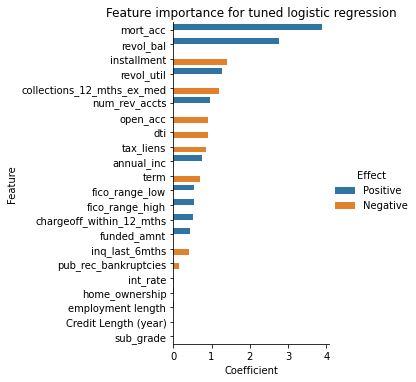

In [580]:

model_features['Effect'] = 'Positive'
model_features.loc[model_features['Importance'] < 0, 'Effect'] = 'Negative'
model_features['Absolute effect'] = abs(model_features['Importance'])
data = model_features.sort_values(by='Absolute effect', ascending=False)
sns.catplot(y= data.index, x='Absolute effect', hue='Effect', kind='bar', data=data)
plt.title(title)
plt.xlabel('Coefficient')
plt.ylabel('Feature')

## Drop _sub_grade_ column and keep _grade_ and train logistic regression

In [394]:
y = df['Status']
X = df.drop(columns=['Status', 'sub_grade'])

# Choose the categorical columns
col_num =X.shape[1]
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

# Undersample

Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)

The new X has the columns added by One Hot Encoder, which has increased the number of columns from 23 to 46


In [395]:
gen2_lr_cv_results = cross_validate(pipe, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
gen2_lr_cv_scores = gen2_lr_cv_results['test_score']
print('Balanced accuaracy scores of 5 fold logistic regression are: ', gen2_lr_cv_scores)
print('Mean of balanced accuaracy scores of 5 fold logistic regression is: ', gen2_lr_cv_scores.mean())

Balanced accuaracy scores of 5 fold logistic regression are:  [0.65348393 0.65125867 0.65139439 0.65641268 0.6543841 ]
Mean of balanced accuaracy scores of 5 fold logistic regression is:  0.6533867523630119


## Feature Selection using SelectKBest

 We will use select best to see if the number of parameters affect model training

In [481]:
result ={}
MeanScore = []
scores_5cv = []
StdScore = []
for i in range(18):
    k_f = 18 - i
    y = df['Status']
    X = df.drop(columns=['Status', 'sub_grade'])
    
    Xcol_names = X.columns
    ycol_name =['Status']
    
    # Undersample

    Xn = X.to_numpy()
    yn = y.to_numpy()
    random_state=42
    RU = RandomUnderSampler()
    X_res, y_res = RU.fit_resample(Xn,yn)

    # Split    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)
    X_train = pd.DataFrame(X_train, columns=Xcol_names)
    y_train = pd.DataFrame(y_train, columns=ycol_name)

    numerical_columns = X.select_dtypes(exclude=['object']).columns
    numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler()), ('sss', SelectKBest(chi2, k=k_f))])


    categorical_columns = X.select_dtypes(include=['object']).columns
    categorical_transformer = OneHotEncoder(drop='if_binary')


    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numerical_columns),
        ("cat", categorical_transformer, categorical_columns),
    ])

    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())])
    cv_result = cross_validate(pipe, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
    Result_scores = cv_result['test_score']
    MeanScore.append(Result_scores.mean())
    StdScore.append(Result_score.std())
    #features_list[kb.get_support()]
    scores_5cv.append(Result_scores)
    result.update({k_f: Result_scores})
        

In [482]:
Result = pd.DataFrame.from_dict(result, orient='index')


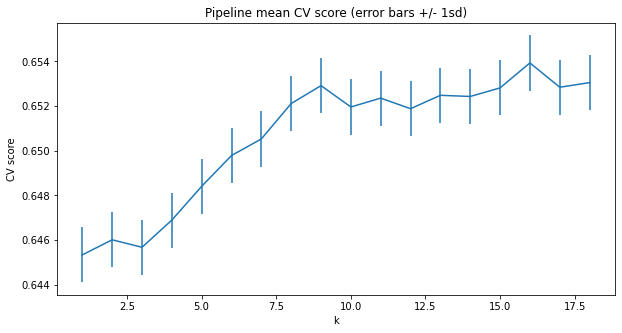

In [483]:
plt.subplots(figsize=(10, 5))
plt.errorbar(Result.index, MeanScore, StdScore)
plt.xlabel('k')
plt.ylabel('CV score')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

Bases on the plot k = 16 gives the highest score. SelectKBest was only applied to the numerical columns and all the categorical columns were incuded. To get the parameters of K, I will run the model with k = 8. 

In [583]:
y = df['Status']
X = df.drop(columns=['Status', 'sub_grade'])
    
Xcol_names = X.columns
ycol_name =['Status']
    
# Undersample

Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

    # Split    
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)
X_train = pd.DataFrame(X_train, columns=Xcol_names)
y_train = pd.DataFrame(y_train, columns=ycol_name)

numerical_columns = X.select_dtypes(exclude=['object']).columns
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler()), ('sss', SelectKBest(chi2, k=8))])


categorical_columns = X.select_dtypes(include=['object']).columns
categorical_transformer = OneHotEncoder(drop='if_binary')


preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_columns),
    ("cat", categorical_transformer, categorical_columns),
])
pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())])

# Do a grid search

grid_params = {'classifier__penalty': ['l1','l2'], 'classifier__C': [0.1,1,10,100,1000]}

# Perform grid search
lr_grid_cv_Kbest = GridSearchCV(pipe, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
lr_grid_cv_Kbest.fit(X_train, y_train)

print(lr_grid_cv_Kbest.best_params_)
lr_grid_cv_Kbest_score = lr_grid_cv_Kbest.best_score_
print('Mean of balanced accuaracy score of tuned logistic regression with best 8 numerical features is: ', lr_grid_cv_Kbest_score)        

{'classifier__C': 100, 'classifier__penalty': 'l2'}
Mean of balanced accuaracy score of tuned logistic regression with best 8 numerical features is:  0.6526599753244616


In [581]:
lr_grid_cv_Kbest.best_estimator_.named_steps.classifier.coef_

array([[-0.91642375, -0.39080347,  3.97028598,  0.37006641, -1.15929754,
        -1.42972792,  0.47036019,  0.47526917,  0.57308746,  0.17222266,
        -0.07768532, -0.11985699, -0.09312429,  0.00580402,  0.06087958,
         0.23789958,  0.10380478,  0.17962275, -0.66874275,  0.01882366,
         0.06306663,  0.02911398,  0.02368626,  0.0355739 ,  0.04916873,
         0.06991077,  0.11581246,  0.03226645,  0.07681616,  0.0070881 ,
        -0.01285317,  0.26698441,  0.03908718,  0.02507242,  0.15320105,
         0.04983524]])

In [512]:
lr_grid_cv_Kbest.best_estimator_.named_steps.preprocessor.transformers[0][1][1].get_support()

NotFittedError: This SelectKBest instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## 9.2. Decision tree classifier <a class='anchor' id='dt'></a>
 


### 9.2.1. Make a pipeline for decision tree <a class='anchor' id='pldt'></a>

Using make_pipeline, a pipeline is created to train decision tree classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [249]:
# Make pipeline
droplist = ['grade', 'Status']
fraction=0.3
PreProcess(droplist, fraction)

pipeTree = make_pipeline( 
    MinMaxScaler(),
    tree.DecisionTreeClassifier()
)

cv_results = cross_validate(pipeTree, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print(cv_scores)
print(cv_scores.mean(), cv_scores.std())


[nan nan nan nan nan]
nan nan


In [251]:
X_train

array([[91.6, 10.73, 0.0, ..., 0.0, 0.0, 19.16808695592654],
       [74.6, 28.05, 0.0, ..., 0.0, 0.0, 7.748276829777477],
       [60.0, 21.43, 0.0, ..., 0.0, 0.0, 23.838956309848932],
       ...,
       [51.4, 31.61, 0.0, ..., 0.0, 0.0, 25.166841208238363],
       [19.0, 24.64, 0.0, ..., 0.0, 0.0, 16.662902044532057],
       [51.4, 18.59, 0.0, ..., 0.0, 0.0, 11.589560360582352]],
      dtype=object)

### 9.2.2. Hyperparameter search for decision tree classifier <a class='anchor' id='gddt'></a>

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [33]:
# Define grid parameters

grid_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'], 'decisiontreeclassifier__max_depth': [3, 6, 9, 12, 15]}

In [34]:
# Perform grid search to find hyperparameters of decision tree

tree_grid_cv = GridSearchCV(pipeTree, param_grid=grid_params, scoring='balanced_accuracy', cv=5, n_jobs=-1)
tree_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [3, 6, 9, 12,
                                                               15]},
             scoring='balanced_accuracy')

### 9.2.3. Decision tree classifier with best parameters <a class='anchor' id='bestdt'></a>

We access the best parameters by using grid.best_params_

In [35]:
tree_grid_cv.best_params_

{'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 9}

We fit a decision tree to the training data by using the best hyperparameters and then, we will look at the importance of the features.

[0.64826076 0.64948558 0.64748642 0.64568441 0.6467749 ]
For the training set, the balanced accuracy is:  0.6550730765460885
              precision    recall  f1-score   support

     Default       0.65      0.69      0.67    182384
  Fully Paid       0.67      0.62      0.64    182317

    accuracy                           0.66    364701
   macro avg       0.66      0.66      0.65    364701
weighted avg       0.66      0.66      0.65    364701



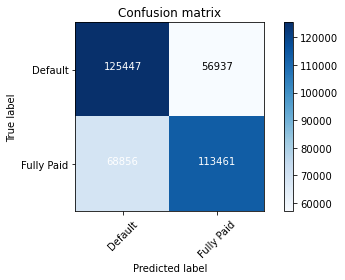

In [38]:
BestTree = tree.DecisionTreeClassifier(criterion="entropy", max_depth =9, random_state = 1234)
pipeTreeBest = make_pipeline(
    MinMaxScaler(),
    BestTree)

cv_results = cross_validate(pipeTreeBest, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print(cv_scores)

pipeTreeBest.fit(X_train, y_train)
y_pred = pipeTreeBest.predict(X_train)
y_pred =pd.Series(y_pred)

print('For the training set, the balanced accuracy is: ', balanced_accuracy_score(y_train, y_pred))

cm = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(cm)

print(classification_report(y_train, y_pred))

It can be seen that the balanced accuracy of the decision tree model is 0.66. The model is performing poorly. 

In [30]:
from sklearn.tree import export_graphviz

import os     
from io import StringIO  

os.environ["PATH"] += os.pathsep + 'C://Users//somfl//Anaconda3//Library//bin//graphviz'

# Now we want to visualize the tree
dot_data = StringIO()

# We can do so with export_graphviz
tree.export_graphviz(BestTree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ['Fully Paid', 'Default'])
# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

184 [label=<emp_length_< 1 year &le; 0.5<br/>gini = 0.267<br/>samples = 2777<br/>value = [441, 2336]<br/>class = Default>, fillcolor="#5eb0ea"] ;
    ^
Expected "}", found '['  (at char 25163), (line:371, col:5)


AttributeError: 'NoneType' object has no attribute 'create_png'

### 9.2.4. Feature importance assessment in the decision tree classifier <a class='anchor' id='fidt'></a>

Using the function I initially defined, I will get the importance of features in the decision tree model.

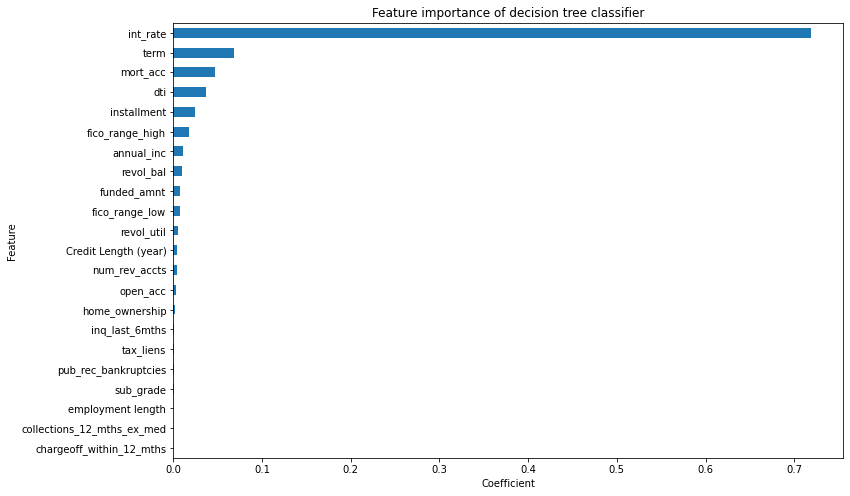

In [39]:
model_features = feature_importance(pipeTreeBest.named_steps.decisiontreeclassifier)
title='Feature importance of decision tree classifier'
plot_feature_importance(model_features, title)

According to the feature importance plot, _interest rate_, _loan term_(either it is 30 month or 60 month loan), _number of mortages_, _debt to income ratio_, _installment_, _Low Fico score_, _revolving balance_ and _high Fico score_ are the most influential parameters in decision tree classifier. Interest rate has a more significant effect than the other parameters.   

Furthermore, number of _tax liens_, _sub grade_, _bank ruptcies_, _employment length_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

## 9.3. Random forest classifier <a class='anchor' id='rf'></a>

### 9.3.1. Make a pipeline for random forest classifier <a class='anchor' id='plrf'></a>

Using make_pipeline, a pipeline is created to train random forest classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [40]:
pipeRF = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=47))
cv_results = cross_validate(pipeRF, X_train, y_train, scoring='balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print(cv_scores)
print(cv_scores.mean(), cv_scores.std())


[0.65438668 0.65516443 0.65327104 0.65281765 0.65266737]
0.6536614335579758 0.0009630709870905471


### 9.3.2. Hyperparameter search for random forest classifier <a class='anchor' id='gdrf'></a>

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [41]:
pipeRF.get_params()

{'memory': None,
 'steps': [('minmaxscaler', MinMaxScaler()),
  ('randomforestclassifier', RandomForestClassifier(random_state=47))],
 'verbose': False,
 'minmaxscaler': MinMaxScaler(),
 'randomforestclassifier': RandomForestClassifier(random_state=47),
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_impurity_split': None,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestcl

In [42]:
# Define a grid for hyperparameter tuning with GridSearchCV
param_grid = { 
    'randomforestclassifier__n_estimators': [50, 100, 150],
    'randomforestclassifier__max_depth' : [3, 6, 9],
    'randomforestclassifier__criterion' :['gini', 'entropy']
}


In [43]:
rf_grid_cv  = GridSearchCV(pipeRF, param_grid = param_grid, scoring='balanced_accuracy', cv = 5, n_jobs = -1)
rf_grid_cv.fit(X_train, y_train)
rf_grid_cv.best_params_

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__n_estimators': 150}

In [45]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)


In [49]:
rf_best_scores = rf_best_cv_results['test_score']
print(rf_best_scores)

print(rf_best_scores.mean(), rf_best_scores.std())

[0.65372013 0.6551275  0.65451056 0.65075404 0.65091856]
0.6530061592538252 0.0018277384608066127


Due to lack of computational power, I will do grid search for each random forest parameter separately

In [50]:
rf_grid_cv.best_estimator_.get_params()

{'memory': None,
 'steps': [('minmaxscaler', MinMaxScaler()),
  ('randomforestclassifier',
   RandomForestClassifier(max_depth=9, n_estimators=150, random_state=47))],
 'verbose': False,
 'minmaxscaler': MinMaxScaler(),
 'randomforestclassifier': RandomForestClassifier(max_depth=9, n_estimators=150, random_state=47),
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_impurity_split': None,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomfore

In [52]:
param_grid = { 
    'randomforestclassifier__n_estimators': [150, 200, 300, 500, 700, 1000],
    'randomforestclassifier__bootstrap': [True],
    'randomforestclassifier__ccp_alpha': [0.0],
    'randomforestclassifier__class_weight': [None],
    'randomforestclassifier__criterion': ['gini'],
    'randomforestclassifier__max_depth': [9],
    'randomforestclassifier__max_features': ['auto'],
    'randomforestclassifier__max_leaf_nodes': [None],
    'randomforestclassifier__max_samples': [None],
    'randomforestclassifier__min_impurity_decrease': [0.0],
    'randomforestclassifier__min_impurity_split': [None],
    'randomforestclassifier__min_samples_leaf': [1],
    'randomforestclassifier__min_samples_split': [2],
    'randomforestclassifier__min_weight_fraction_leaf': [0.0],
    'randomforestclassifier__n_jobs': [None],
    'randomforestclassifier__oob_score': [False],
    'randomforestclassifier__random_state': [47],
    'randomforestclassifier__verbose': [0],
    'randomforestclassifier__warm_start': [False]
}
rf_grid_cv  = GridSearchCV(pipeRF, param_grid = param_grid, scoring='balanced_accuracy', cv = 5, n_jobs = -1)

rf_grid_cv.fit(X_train, y_train)
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
print(rf_best_scores)
print(rf_best_scores.mean(), rf_best_scores.std())

rf_grid_cv.best_params_

[0.65417255 0.65434604 0.65482588 0.65046614 0.65128873]
0.6530198679118442 0.0017814308585385507


{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_impurity_split': None,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__n_estimators': 700,
 'randomforestclassifier__n_jobs': None,
 'randomforestclassifier__oob_score': False,
 'randomforestclassifier__random_state': 47,
 'randomforestclassifier__verbose': 0,
 'randomforestclassifier__warm_start': False}

In [71]:
rf_grid_cv.cv_results_


{'mean_fit_time': array([ 314.68339   ,  389.65662193,  542.46116366,  932.25998311,
        1382.05743041, 1604.89631362]),
 'std_fit_time': array([  3.90875957,  18.21267217,   1.50485819,  23.77037153,
         19.30763435, 157.18085521]),
 'mean_score_time': array([ 5.8301856 ,  7.62430568, 10.12287459, 17.87661366, 24.7633162 ,
        20.08009648]),
 'std_score_time': array([0.48897925, 0.77858939, 0.35598688, 2.22993614, 4.46050002,
        2.24134058]),
 'param_randomforestclassifier__bootstrap': masked_array(data=[True, True, True, True, True, True],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_randomforestclassifier__ccp_alpha': masked_array(data=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_randomforestclassifier__class_weight': masked_array(data=[None, None, None, None, None, None],
       

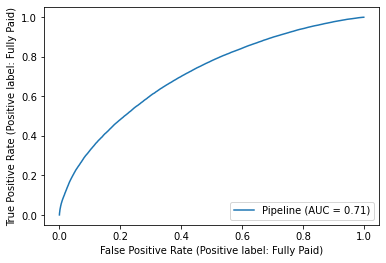

In [53]:
#print(roc_auc_score(y_test, y_pred))
metrics.plot_roc_curve(rf_grid_cv.best_estimator_, X_test, y_test)

In [ ]:
param_grid = { 
    'randomforestclassifier__n_estimators': [700],
    'randomforestclassifier__bootstrap': [True],
    'randomforestclassifier__ccp_alpha': [0.0],
    'randomforestclassifier__class_weight': [None],
    'randomforestclassifier__criterion': ['gini'],
    'randomforestclassifier__max_depth': [6, 9, 15, 25, 35],
    'randomforestclassifier__max_features': ['auto'],
    'randomforestclassifier__max_leaf_nodes': [None],
    'randomforestclassifier__max_samples': [None],
    'randomforestclassifier__min_impurity_decrease': [0.0],
    'randomforestclassifier__min_impurity_split': [None],
    'randomforestclassifier__min_samples_leaf': [1],
    'randomforestclassifier__min_samples_split': [2],
    'randomforestclassifier__min_weight_fraction_leaf': [0.0],
    'randomforestclassifier__n_jobs': [None],
    'randomforestclassifier__oob_score': [False],
    'randomforestclassifier__random_state': [47],
    'randomforestclassifier__verbose': [0],
    'randomforestclassifier__warm_start': [False]
}
rf_grid_cv2  = GridSearchCV(pipeRF, param_grid = param_grid, scoring='balanced_accuracy', cv = 5, n_jobs = -1)

rf_grid_cv2.fit(X_train, y_train)
rf_best_cv_results2 = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores2 = rf_best_cv_results2['test_score']
print(rf_best_scores2)
print(rf_best_scores2.mean(), rf_best_scores2.std())

rf_grid_cv2.best_params_

### 9.3.3. Feature importance assessment of random forest classifier <a class='anchor' id='firf'></a>

We fit a random forest classifier to the training data by using the best hyperparameters. Then we will use the model on the test data and will check to see the balanced accuracy score of the model. Finally, we will look at the importance of the features.

In [57]:
rf_grid_cv.best_estimator_.fit(X_train, y_train)

y_pred = rf_grid_cv.best_estimator_.predict(X_train)
y_pred =pd.Series(y_pred)

print('For the training set, the balanced accuracy is: ', balanced_accuracy_score(y_train, y_pred))

cm = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(cm)

print(classification_report(y_train, y_pred))

KeyboardInterrupt: 

The balanced accuracy score of the random forest is 50% which means the model is performing very poorly. When compared with the decision tree classifier and the logistic regression classifier, which had 0.54 balanced accuracy scores, random forest is a bit worse.

Using the two functions we visualize the relative importance of the parameters.

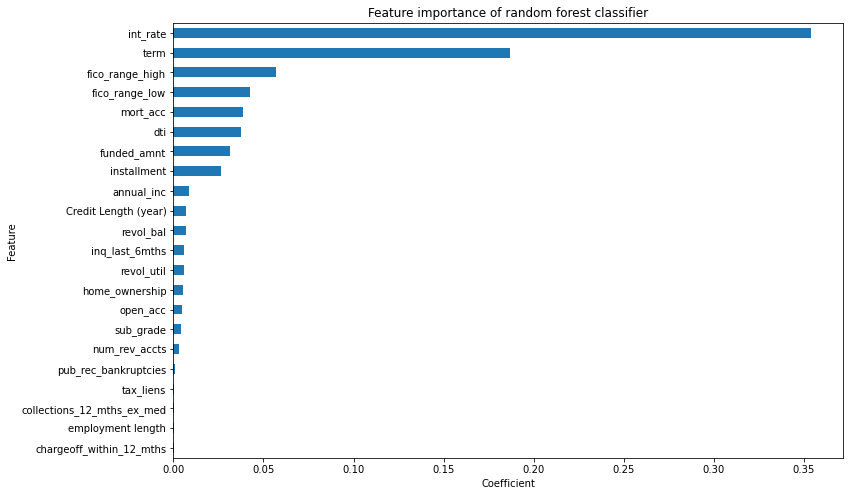

In [76]:
# Plot feature importance for random forest

model_features = feature_importance(pipeRFBest.named_steps.randomforestclassifier)
title='Feature importance of random forest classifier'
plot_feature_importance(model_features, title)

As shown in the plot,  _interest rate_, _loan term_(either it is 30 month or 60 month), _higher Fico score_ and _low Fico score_, _debt to income ratio_ , _number of mortages_, _funded amount_ and _installment_ are the most influential parameters.

It is worth mentioning that the decision tree reached to almost similar conclusion in the previous section. In a decision tree classifier, the most influential parameters were interest rate, loan term(either it is 30 month or 60 month loan), number of mortages, debt to income ratio, installment, Low Fico score, revolving balance and high Fico score.  

Furthermore, Among the parameters, _employment length_, number of _tax liens_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

## 9.4. Gradient boosting classifier <a class='anchor' id='GB'></a>

### 9.4.1. Make a pipeline for gradient boosting classifier <a class='anchor' id='plgb'></a>

Using make_pipeline, a pipeline is created to train gradient boosting classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [55]:
pipeXG = make_pipeline(MinMaxScaler(), XGBClassifier())

cv_results = cross_validate(pipeXG, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print(cv_scores)

pipeXG.fit(X_train,y_train)
y_pred = pipeXG.predict(X_train)
y_pred =pd.Series(y_pred)
print(classification_report(y_pred,y_train))

print('For the training set, the balanced accuracy is: ', balanced_accuracy_score(y_train, y_pred))

[12:40:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:40:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

### 9.4.2. Hyperparameter tuning for gradient boosting classifier <a class='anchor' id='gdgb'></a>

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [56]:
parameters = {
    'xgbclassifier__max_depth':[3, 6, 9],
    'xgbclassifier__n_estimator':[100, 200, 500],
    'xgbclassifier__learning_rate': [0.25, 0.2, 0.1],
    }
grid_search = GridSearchCV(pipeXG, param_grid= parameters, cv=5, scoring='balanced_accuracy')
grid_search.fit(X_train,y_train)

[12:51:56] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:51:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:20] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:52:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default eva

[12:58:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:37] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:58:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:59:24] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in langua

[13:10:06] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:10:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:10:58] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:10:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default eva

KeyboardInterrupt: 

In [ ]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

### 9.4.3. Gradient boosting feature importance assessment <a class='anchor' id='figb'></a>

In [81]:
BestXG = XGBClassifier(random_state=47,gamma=2, learning_rate=0.25, max_delta_step=0, min_child_weight=0,  subsample=1, n_estimators=10)
pipeXgBest = make_pipeline(MinMaxScaler(), BestXG)
pipeXgBest.fit(X_train, y_train)

y_pred = pipeXgBest.predict(X_train)
y_pred = pd.Series(y_pred) 

print('For the training set, the balanced accuracy is: ', balanced_accuracy_score(y_train, y_pred))

y_pred = pipeXgBest.predict(X_test)
y_pred =pd.Series(y_pred)

print('For the testing set, the balanced accuracy is: ', balanced_accuracy_score(y_test, y_pred))

[12:22:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the training set, the balanced accuracy is:  0.5261816216790653
For the testing set, the balanced accuracy is:  0.5253736836682769


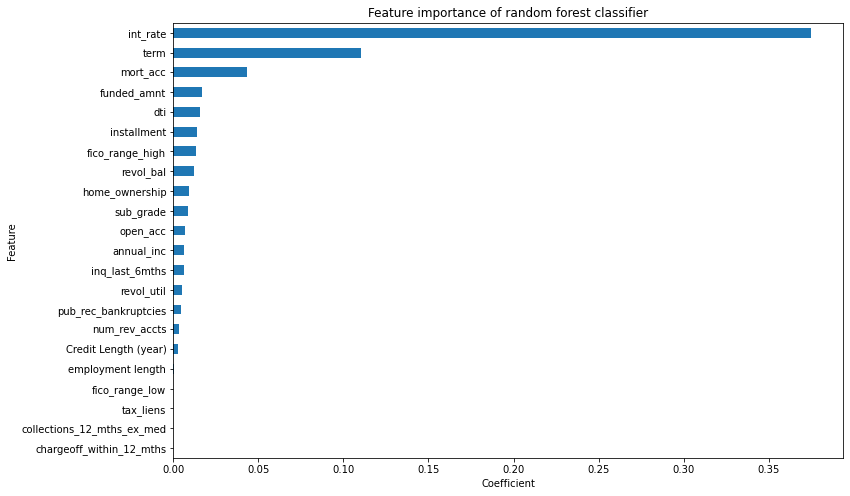

In [84]:
model_features = feature_importance(pipeXgBest.named_steps.xgbclassifier)
Title = ' Feature importance for gradient boosting classifier'
plot_feature_importance(model_features, title)

According to the balanced accuracy score, gradient boosting is better than random forest but as not as good decision tree or logistic regression clasiifiers. However, the score is 52% and the models performs poorly.

According to the feature importance plot, _interest rate_, _term_, the number of _mortage accounts_ , _funded amount_, _debt to income ratio_, _installment_, _high Fico score_ and _revolving balance are the most influential parameters in the classification. _interset rate_ has a significant effect compared with other parameters.

Among the parameters, _employment length_, number of _tax liens_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

In [ ]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

## 10. Summary <a class='anchor' id='discussion'><a/>

In this notebook four classifiers were applied to the data.
In each model training, a pipeline including scaling and modeling steps was created and bu using GridSearchCV, hyperparameters were tuned. 

All models reached to almost same balanced accuracy score of about %54, which is due to the fact that the data is imbalanced.

Random forest classifier, decision tree and gradient boosting, they all found _interest rate_, _term_, the number of _mortage accounts_ , _funded amount_, _debt to income ratio_, _installment_, _Fico score_ as influential parameters.

According to all models _employment length_, number of _tax liens_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

## 11. Using RandomUnderSampler 

In [ ]:
# Defining X and y

y = df['Status']
X = df.drop(columns=['Status', 'id', 'Unnamed: 0', 'grade', 'verification_status'])

In [ ]:
# Choosing the categorical columns

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# creating instance of one-hot-encoder

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)

In [41]:
pipeTree = make_pipeline( 
    MinMaxScaler(),
    tree.DecisionTreeClassifier()
)

In [48]:
BestTree = tree.DecisionTreeClassifier()
pipeTreeBest = make_pipeline(BestTree)
pipeTreeBest.fit(X_train, y_train)


y_pred = pipeTreeBest.predict(X_train)
y_pred =pd.Series(y_pred)

print('For the training set, the balanced accuracy is: ', balanced_accuracy_score(y_train, y_pred))

y_pred = pipeTreeBest.predict(X_test)
y_pred =pd.Series(y_pred)

print('For the testing set, the balanced accuracy is: ', balanced_accuracy_score(y_test, y_pred))

For the training set, the balanced accuracy is:  1.0
For the testing set, the balanced accuracy is:  0.5707526814400763


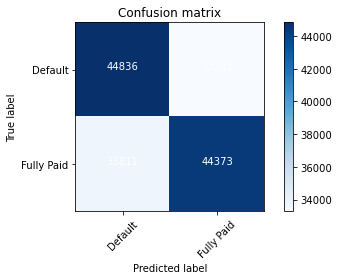

In [49]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

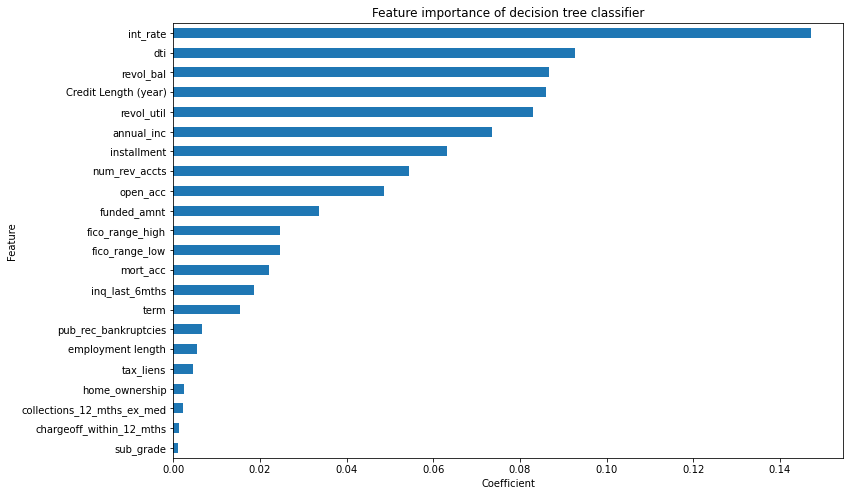

In [50]:
model_features = feature_importance(pipeTreeBest.named_steps.decisiontreeclassifier)
title='Feature importance of decision tree classifier'
plot_feature_importance(model_features, title)